In [2]:
# 📚 Import thư viện
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_preprocess_input

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
BATCH_SIZE = 32

# Dùng ImageDataGenerator cho train
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
)

train_generator = train_datagen.flow_from_directory(
    '../../../Bai_4/data_algorithm/train',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load toàn bộ test ảnh
test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess_input,
)

full_test_generator = test_datagen.flow_from_directory(
    '../../../Bai_4/data_algorithm/test',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Tải toàn bộ ảnh test ra numpy array
test_images = []
test_labels = []

for i in range(len(full_test_generator)):
    x, y = full_test_generator[i]
    test_images.append(x[0])
    test_labels.append(y[0])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Chia đôi test thành val và test
X_val, X_test, y_val, y_test = train_test_split(
    test_images, test_labels, test_size=0.5, random_state=42, stratify=test_labels
)

# Tạo generator từ numpy
val_generator = test_datagen.flow(
    X_val, y_val, batch_size=1, shuffle=False
)

test_generator = test_datagen.flow(
    X_val, y_val, batch_size=1, shuffle=False
)
print(f"Tổng số ảnh train: {train_generator.n}")
print(f"Tổng số ảnh val: {val_generator.n}")
print(f"Tổng số ảnh test: {test_generator.n}")

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Tổng số ảnh train: 28709
Tổng số ảnh val: 3589
Tổng số ảnh test: 3589


In [4]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV3Small

# Base model
base_model = MobileNetV3Small(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# Functional API
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(7, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,687 (3.90 MB)

 Trainable params: 670,759 (2.56 MB)

 Non-trainable params: 350,928 (1.34 MB)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 168s 182ms/step - accuracy: 0.3998 - loss: 1.5333 - val_accuracy: 0.4767 - val_loss: 1.4939
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 152s 170ms/step - accuracy: 0.5710 - loss: 1.1667 - val_accuracy: 0.4517 - val_loss: 1.7366
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 158s 176ms/step - accuracy: 0.6048 - loss: 1.0683 - val_accuracy: 0.5821 - val_loss: 1.1432
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 167s 186ms/step - accuracy: 0.6512 - loss: 0.9549 - val_accuracy: 0.6155 - val_loss: 1.0645
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 180s 200ms/step - accuracy: 0.6849 - loss: 0.8617 - val_accuracy: 0.6088 - val_loss: 1.1266
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 163s 181ms/step - accuracy: 0.7166 - loss: 0.7794 - val_accuracy: 0.6080 - val_loss: 1.0997
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 185s 206ms/step - accuracy: 0.7573 - loss: 0.6865 - val_accuracy: 0.6264 - val_loss: 1.1153


3589/3589 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.6027 - loss: 1.1133
Test Accuracy: 61.55%
3589/3589 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step


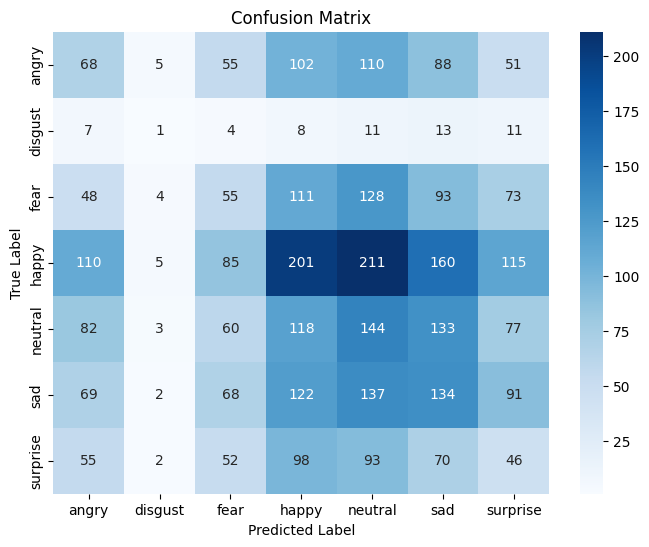

In [7]:
# Accuracy
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc * 100:.2f}%")

# Confusion Matrix
y_true = np.argmax(y_test, axis=1)
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Nếu cần lấy label names
class_labels = list(full_test_generator.class_indices.keys())

# Vẽ confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [8]:
model.save("mobilenetv3_fer2013_low_light_and_algorithm_V3.keras")  # lưu đúng định dạng mới
size_mb = os.path.getsize("mobilenetv3_fer2013_low_light_and_algorithm_V3.keras") / (1024 * 1024)
print(f"Model Size: {size_mb:.2f} MB")

Model Size: 9.59 MB


In [9]:
from sklearn.metrics import f1_score

# F1-Score macro (trung bình đều các lớp)
f1_macro = f1_score(y_true, y_pred_classes, average='macro')

# F1-Score micro (toàn bộ TP, FP, FN gộp lại)
f1_micro = f1_score(y_true, y_pred_classes, average='micro')

# F1-Score weighted (có tính đến số lượng mẫu từng lớp)
f1_weighted = f1_score(y_true, y_pred_classes, average='weighted')

print(f"F1-Score (Macro): {f1_macro * 100:.2f}%")
print(f"F1-Score (Micro): {f1_micro * 100:.2f}%")
print(f"F1-Score (Weighted): {f1_weighted * 100:.2f}%")

F1-Score (Macro): 14.98%
F1-Score (Micro): 18.08%
F1-Score (Weighted): 17.97%


In [12]:
# Inference Time
import time
start = time.time()
_ = model.predict(test_generator)
end = time.time()

inference_time = (end - start) / len(X_test) * 1000  # ms per image
print(f"Average Inference Time: {inference_time:.2f} ms/image")

3589/3589 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step
Average Inference Time: 7.22 ms/image
